In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import time

In [2]:
# Errors
class ServerError(BaseException):
    def __init__(self):
        pass
    def __str__(self):
        return "Server Error. :("
class TimedOut(BaseException):
    def __init__(self):
        pass
    def __str__(self):
        return "You have run out of time. :("
class BadInput(BaseException):
    def __init__(self):
            pass
    def __str__(self):
        return "Input exceeds domain. x,y [0,30)"
class APILimit(BaseException):
    def __init__(self):
            pass
    def __str__(self):
        return "Exceeded 2 API calls per second."
class EndOfGame(BaseException):
    def __init__(self):
            pass
    def __str__(self):
        return "End of Game."

In [3]:
# Agents
## Base Agent
class Agent():
    def __init__(self,name):
        self.name = name
        self.g = None
        
    def __str__(self):
        return self.name
    
## Random   
class Random(Agent):
    def __init__(self):
        super().__init__("Random")
        self.g = Game()
        self.g.start()    
    def move(self):
        self.g.guess(np.random.randint(29),np.random.randint(29))
        
## Depth-Breath   
class DepthBreath(Agent):
    def __init__(self,n):
        super().__init__("Neighbor")
        self.g = Game()
        self.g.start()
        self.max_depth = n
        
    def move(self):
        mask = 1-self.g.is_empty
        smoothing = np.zeros((30,30))
        for i in range(30):
            for j in range(30):
                if i <= 27:
                    a = i
                else:
                    a = 27
                if j <= 27:
                    b = j
                else:
                    b = 27
                smoothing[i,j] = self.g.board[a:a+3,b:b+3].mean()
        e_util = mask * smoothing * (self.g.guesses < self.max_depth)
        index = e_util.argmax()
        x = (index - (index % 30))//30
        y = index % 30
        if e_util.max() == 0 or np.random.random() <= 0.08:
            self.g.guess(np.random.randint(29),np.random.randint(29))
        else:
            self.g.guess(x,y)

In [4]:
# API Interface
class Game:
    def __init__(self):
        self.url = "https://api.gaimbot.com/games/gold-retriever"
        self.id = None
        self.score = 0.0
        self.digs_remaining = 100
        self.board = np.zeros((30,30))
        self.guesses = np.zeros((30,30))
        self.is_empty = np.zeros((30,30))
        self.message_history = list()
        self.move_history = list()
    def __str__(self):
        return "Gold Retriever!!!"
    
    def display(self,index=0): # index {1,2,3}
        res = [self.board,self.guesses,self.is_empty]
        plt.figure(figsize=(10,10))
        sns.heatmap(res[index],cmap="Greys",square=True,cbar=False,annot=True,xticklabels=False,yticklabels=False)
        plt.title("Score: {:.3f}".format(self.score))
        plt.show()
    
    def start(self):
        res = requests.post(url=self.url+'/new')
        if res.status_code != 201:
            raise ServerError()
        state = res.json()
        print(state)
        self.id = state['id']
        self.message_history.append(state['message'])
        
    def guess(self,x,y):
        if self.digs_remaining == 0:
            raise EndOfGame()
        if x >= 30 or y >= 30:
            raise BadInput()
        res = requests.post(url=self.url+"/{}/dig?cell={}".format(self.id,30*x+y))
        state = res.json()
        if res.status_code == 429:
            raise APILimit()
        if res.status_code != 200:
            raise ServerError()
        self.message_history.append(state['message'])
        self.move_history.append((x,y,state['score'] - self.score))
        self.board[x,y] += state['score'] - self.score
        self.score = state['score']
        self.guesses[x,y] += 1
        self.digs_remaining = state['digs_remaining']
        if state['message'][0:14] == "Drat, nothing!":    
            self.is_empty[x,y] = 1

In [35]:
# update username
username="duck"
res = requests.post(url="https://api.gaimbot.com/games/gold-retriever/username?username={}".format(username))
res.json()

'username updated'

In [36]:
res = requests.post(url="https://api.gaimbot.com/games/gold-retriever/new")

In [37]:
res.headers

{'content-type': 'application/json', 'x-rate-limit-limit': '3600', 'x-rate-limit-remaining': '0', 'x-rate-limit-reset': '16112.871942', 'X-Cloud-Trace-Context': 'b9ce4f46008de0eb9c32a5f9dcc63ff0', 'Date': 'Mon, 05 Sep 2022 19:31:27 GMT', 'Server': 'Google Frontend', 'Content-Length': '165'}

In [10]:
def test_agent(agent):
    while agent.g.digs_remaining:
        time.sleep(.7)
        try:
            agent.move()
        except:
            time.sleep(2)
    agent.g.display(1)

{'id': '93d6862a-5b8a-42c7-b417-f110f6c0a862', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


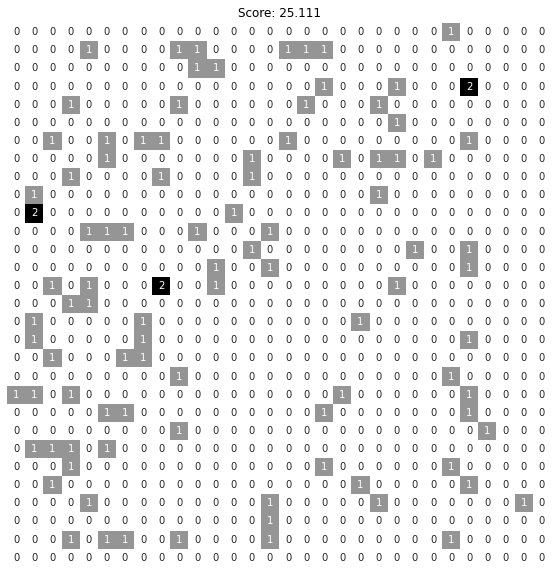

{'id': 'f1c2c6b1-b49b-4b79-965d-6de92569b422', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


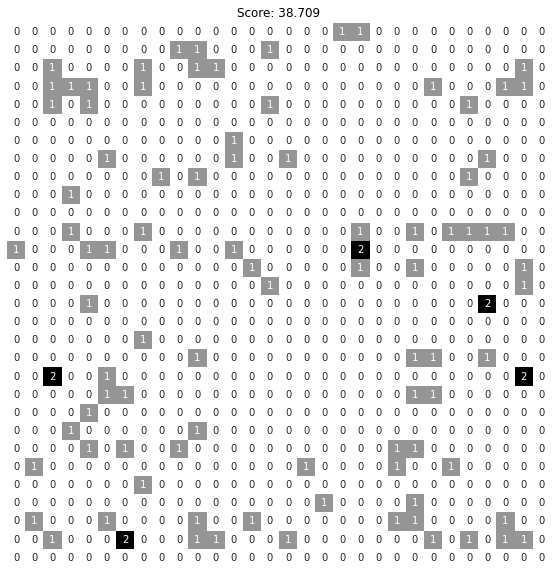

{'id': '28223e1b-5867-4bae-b154-934e7fa164fe', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


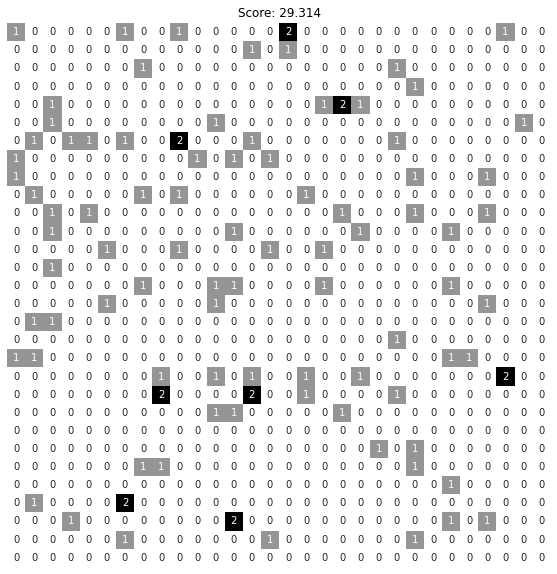

{'id': '4b87c765-218e-4ad9-a85a-d69b69260087', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


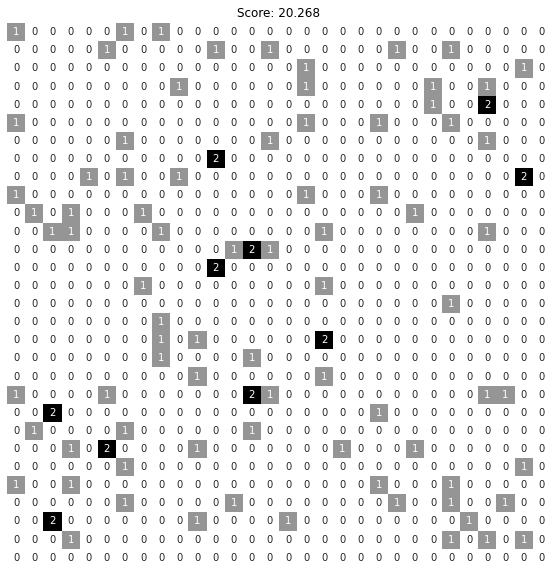

{'id': '191dd4be-2b39-4eb8-8406-0977f815da33', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


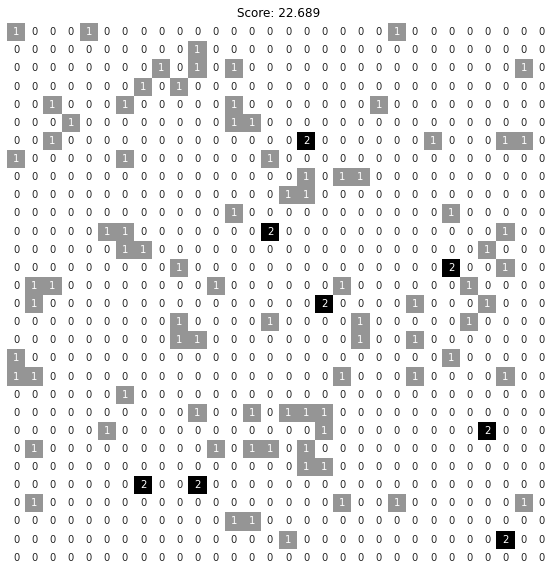

{'id': '214f09a0-f631-42dd-bc19-ad426254d526', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


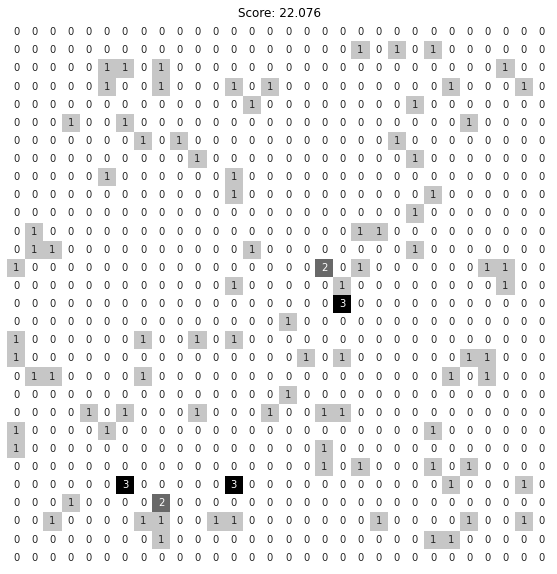

{'id': 'db810c8c-0c15-42f2-b5d3-2b9a710632a0', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


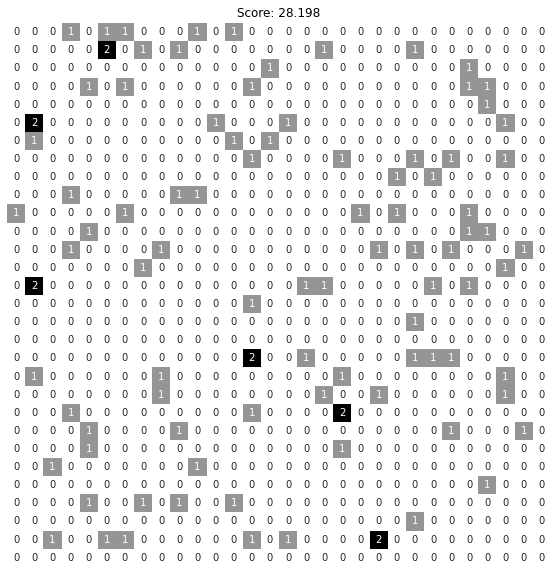

{'id': '892cf027-0a05-4a2b-a8c2-f086d0640db3', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


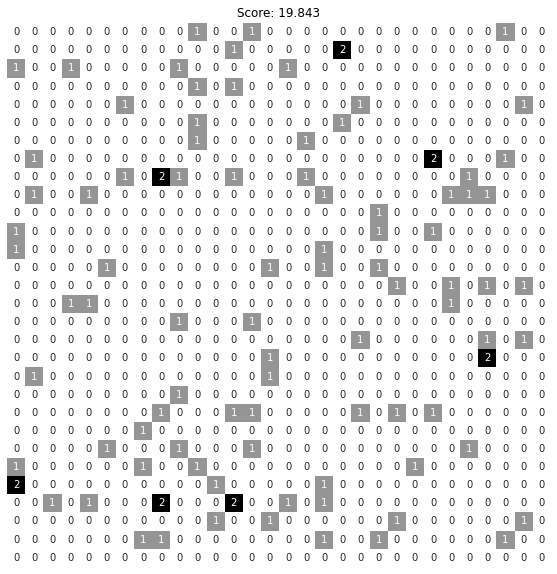

{'id': 'c8f04659-fbf0-4b43-b4fd-5d1569acea48', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


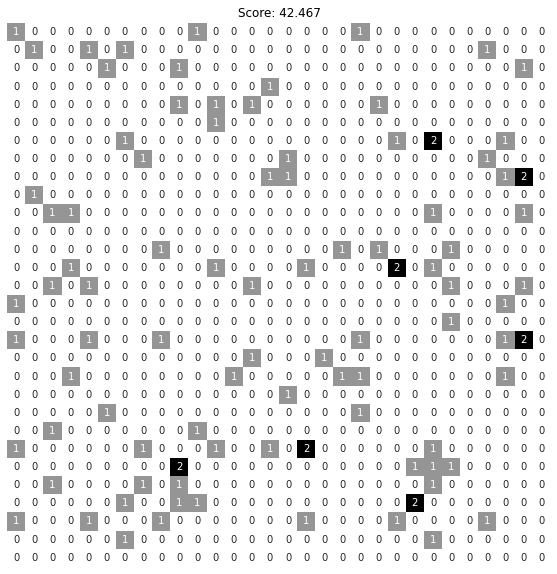

{'id': '061530a2-ca41-48ae-9397-a7751b2345d8', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


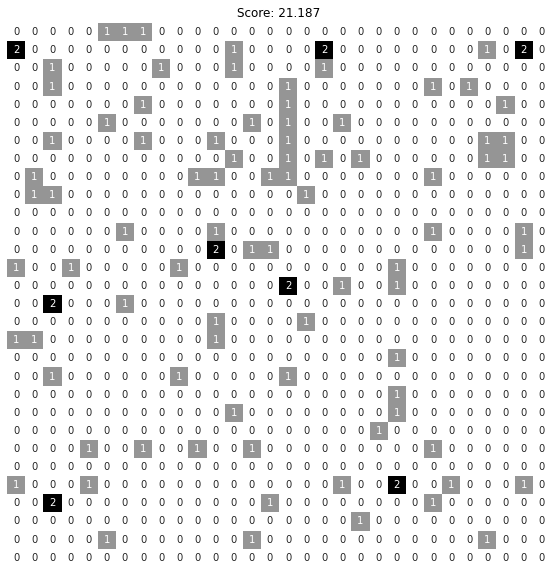

{'id': 'a59d50c2-4c4a-4c63-8cce-006c4b13881e', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


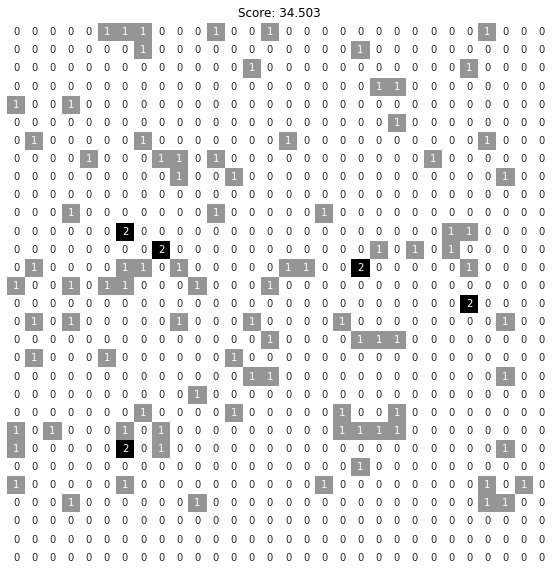

{'id': '1a9a9157-54d4-42e8-afbc-9ef04032aafb', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


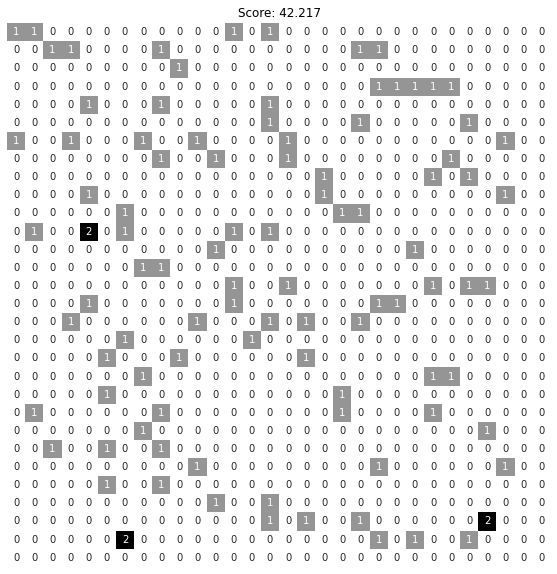

{'id': '796a8fb3-040a-49d2-a2c9-28ddb2f37741', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


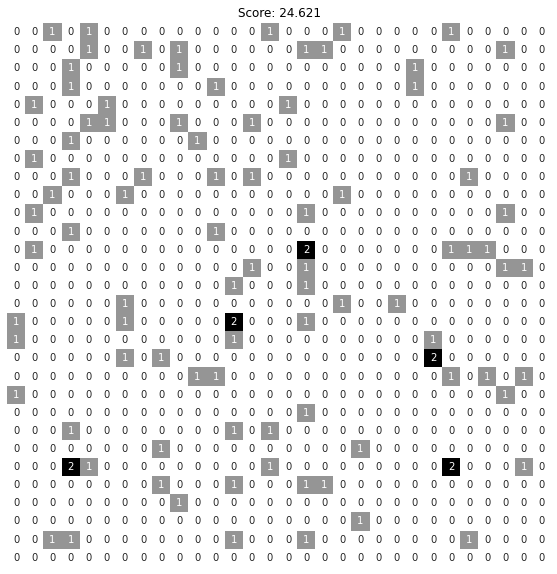

{'id': 'fad53be6-f692-4874-ab04-1b85c2be3c04', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


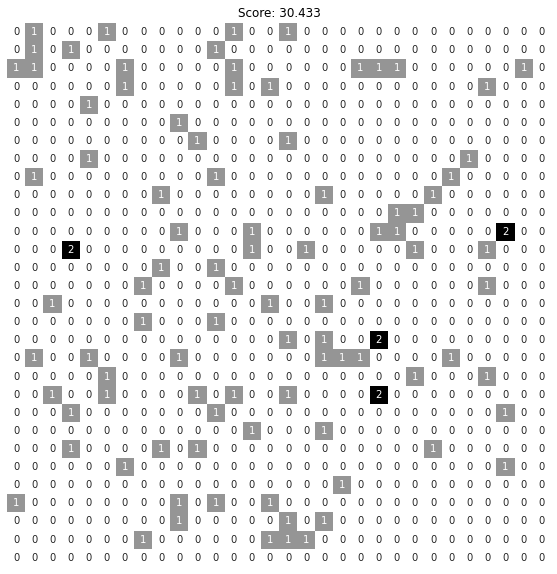

{'id': 'd4581d06-3b0b-46de-9ad0-284c357ba0ad', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


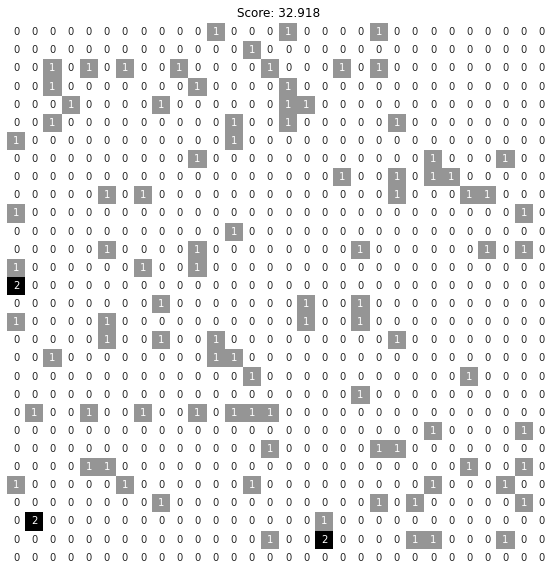

{'id': '335565da-a6d3-413e-a2a2-90c2a44f39af', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


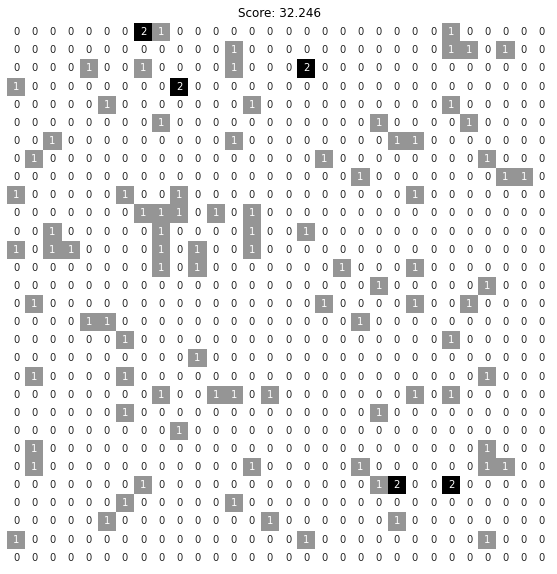

{'id': 'aa057b94-dff9-4865-824f-652f60be30b9', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


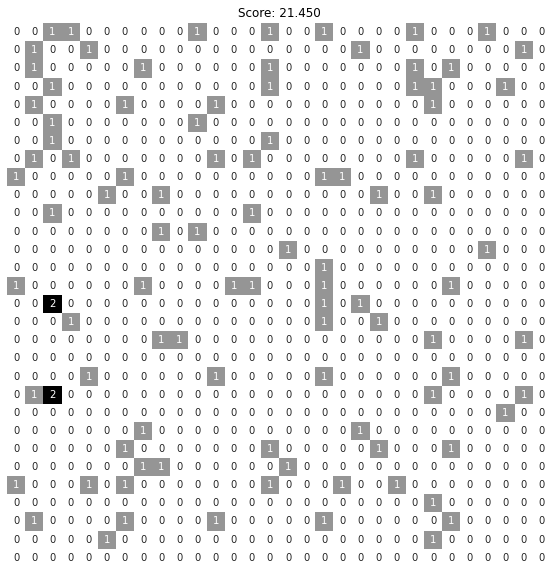

{'id': '158600e9-4c07-4a81-b8b7-e0a26b69ec02', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


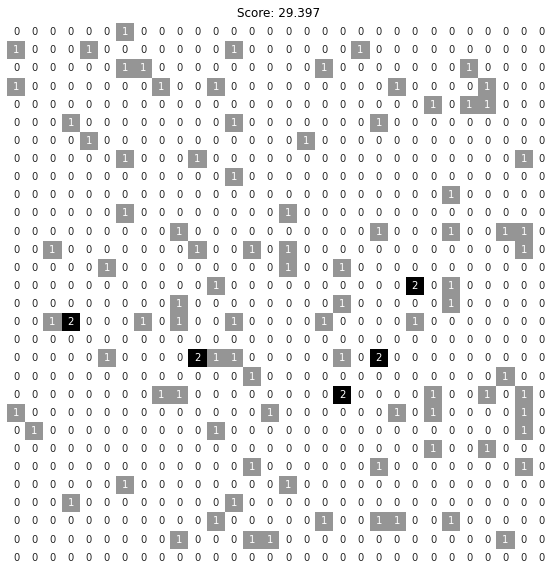

{'id': '5965dd52-c9c4-49e9-a7ca-d438afc71834', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


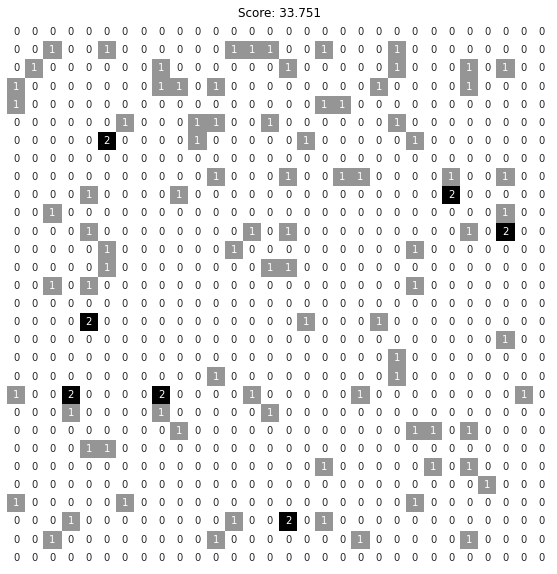

{'id': 'af2eb5fe-d149-4b90-870c-bbcd7cae5d8a', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


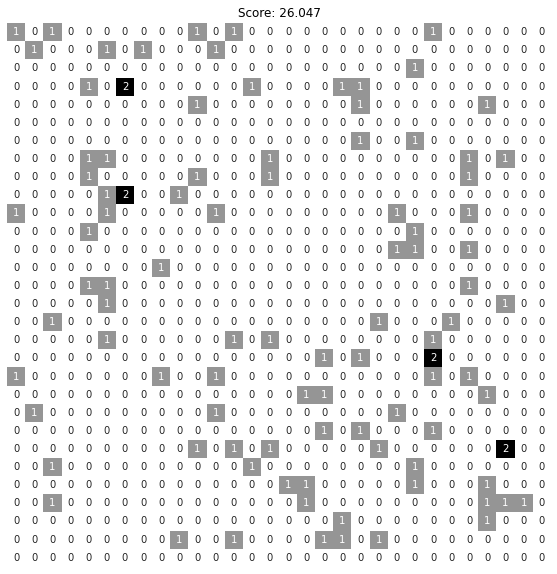

{'id': '3484f65f-8b53-4b13-ae64-95082b8a15f9', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


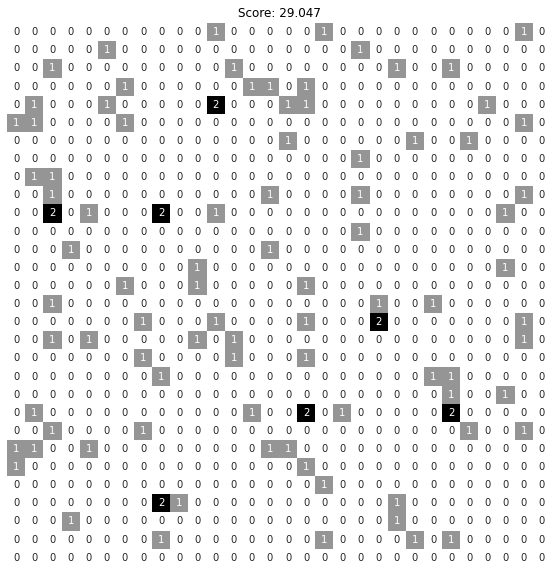

{'id': '5c64e937-d2f7-458f-96a2-adb1a9c937c7', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


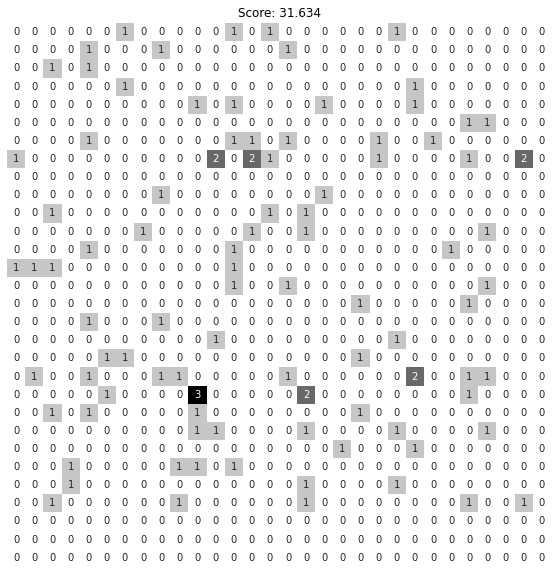

{'id': '53830850-0625-4758-bc79-87615c349e5a', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


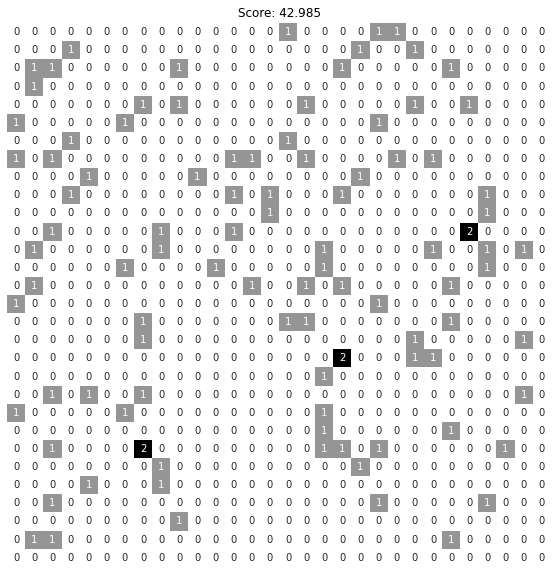

{'id': 'f2838b97-c177-4f97-8f85-7d2cc8c7ccbd', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


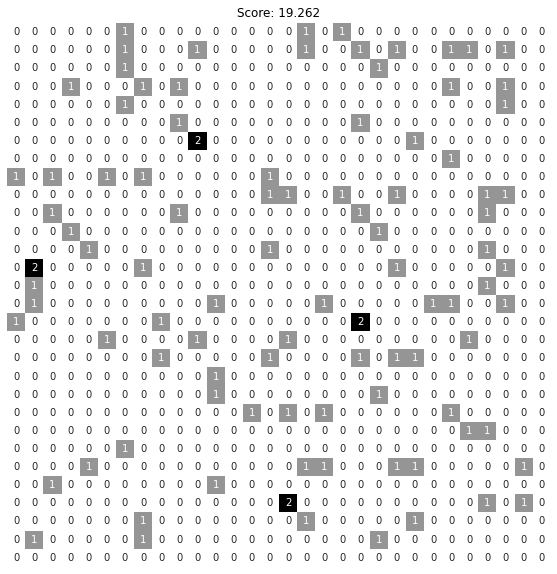

{'id': '91c00366-0209-4ff2-803c-715de423bb64', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


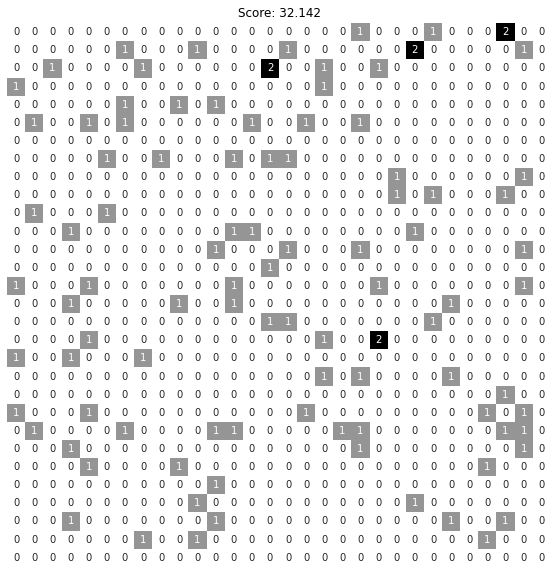

{'id': 'a52ecf49-8dc5-46de-8489-2ea452d3a03c', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


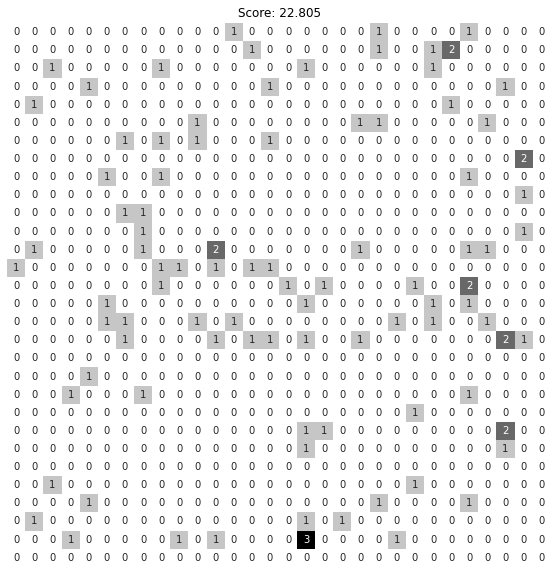

{'id': '44920a50-e3af-4409-b95c-5ef0f4148860', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


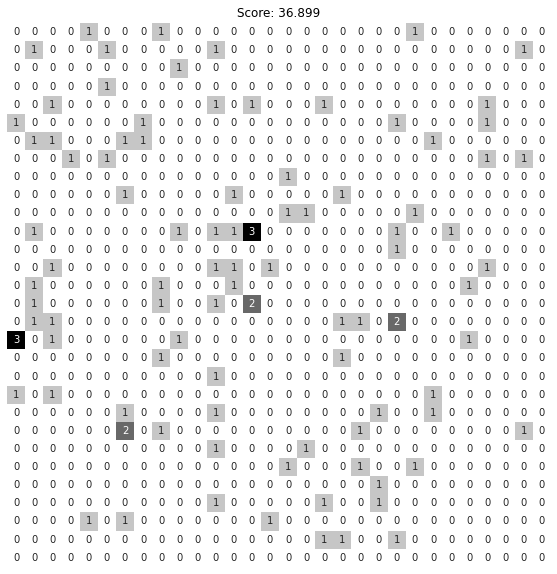

{'id': '72615242-b6ec-4397-be86-efbe74398f45', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


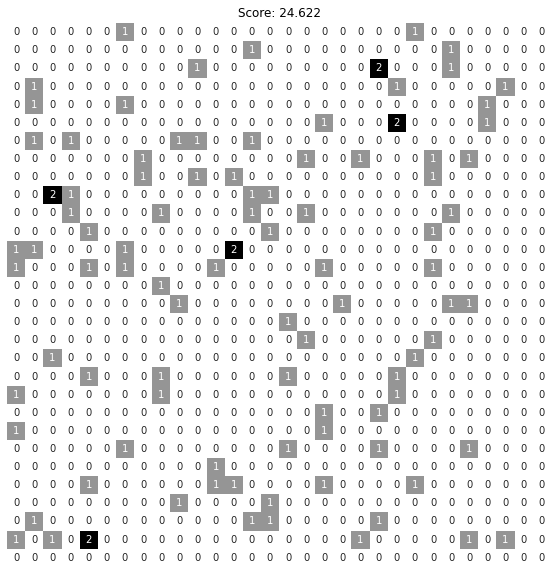

{'id': '08954c37-8db3-42c5-8bc1-0c3f5cc5c9a9', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


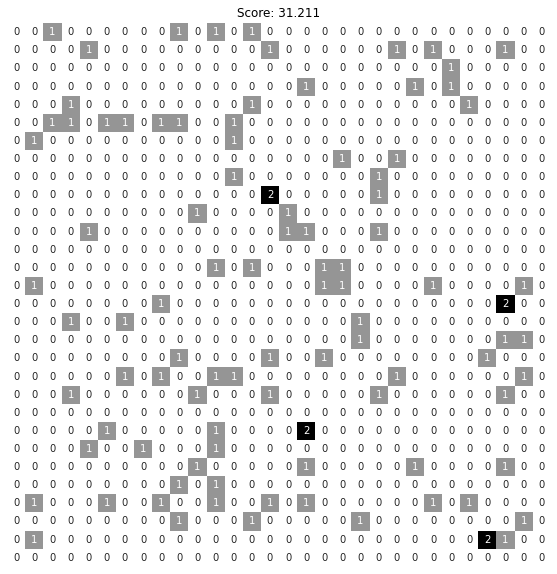

{'id': 'a8b02ceb-d131-4339-9b3c-7488df62a32f', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


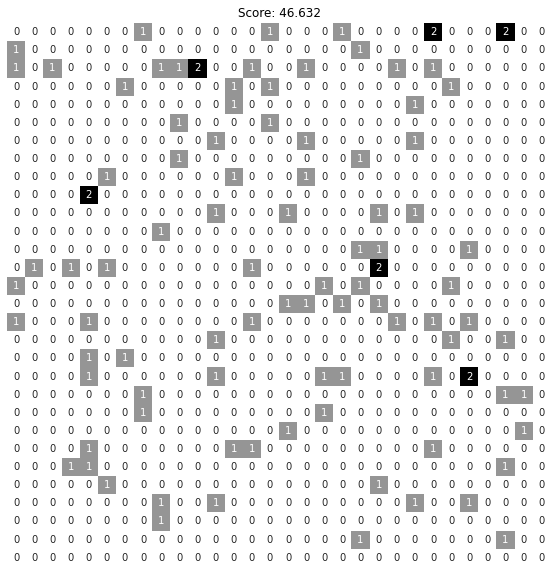

C:\Users\dmarq\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Random')

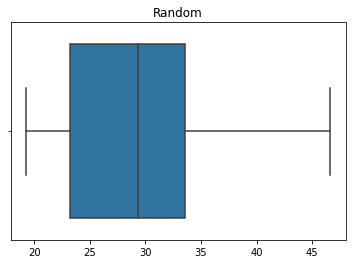

In [47]:
scores1 = []
for i in range(30):
    a2 = Random()
    test_agent(a2)
    scores1.append(a2.g.score)
scores1 = np.array(scores1)
sns.boxplot(scores1)
plt.title("Random")

{'id': '35eec86a-8605-4449-bd57-7d725f83aa62', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


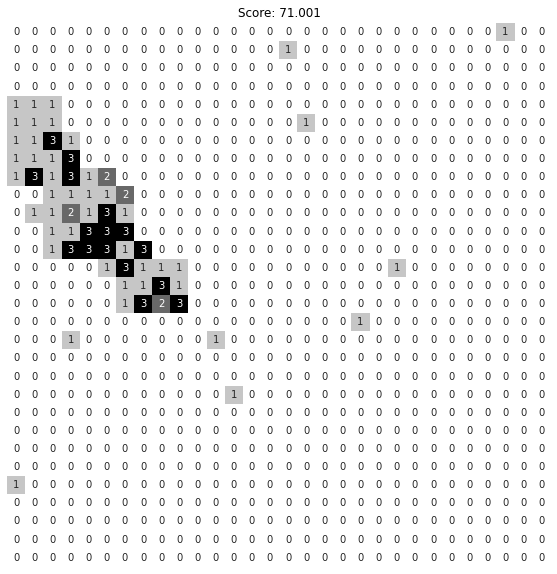

{'id': '5d68585f-5757-49ad-ad6f-676ab2d23204', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


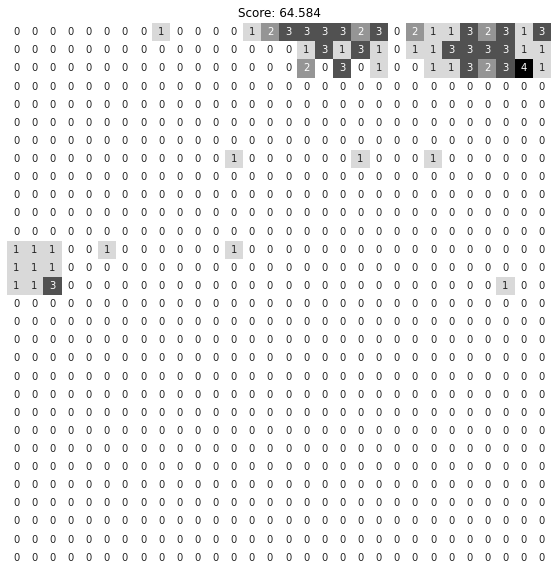

{'id': '0688bfcc-89c0-433c-bbc0-4bb130be5e71', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


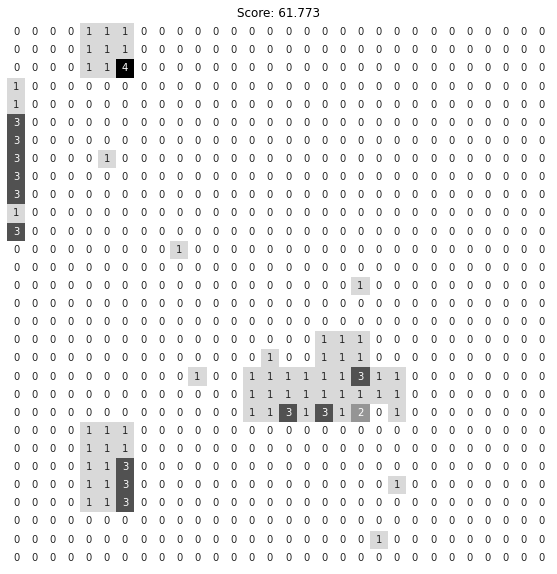

{'id': '5eaf6159-e135-4604-8b66-719541da20cd', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


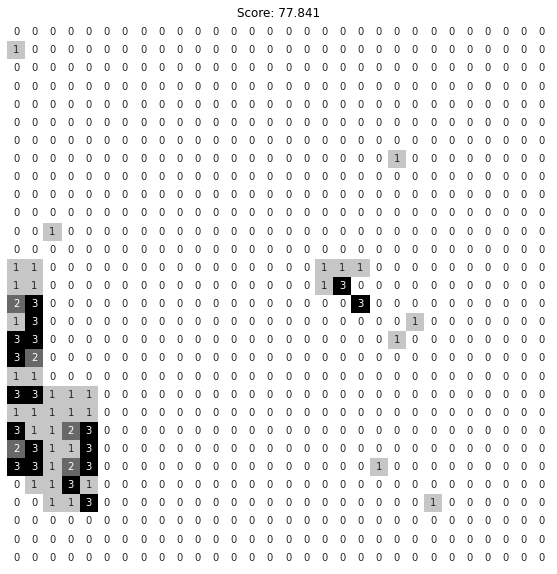

{'id': 'e28af9fa-159c-4a43-b1f4-c7c42c57d7b8', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


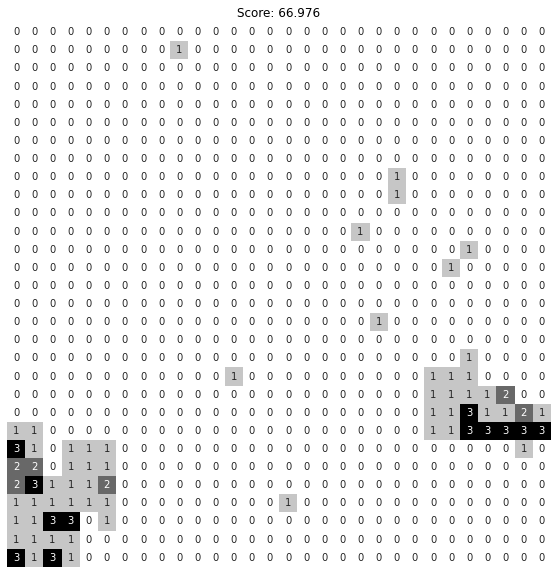

{'id': '8a1d44fa-359e-46df-b185-7a1d7720992a', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


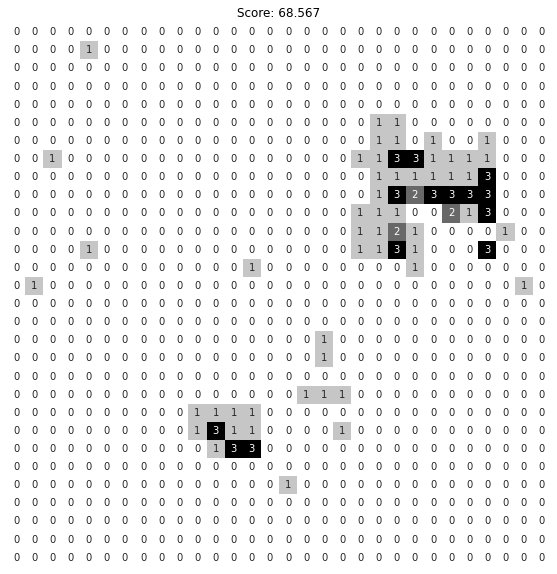

{'id': '5559e0e2-5b7b-4d17-aac8-c88791972969', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


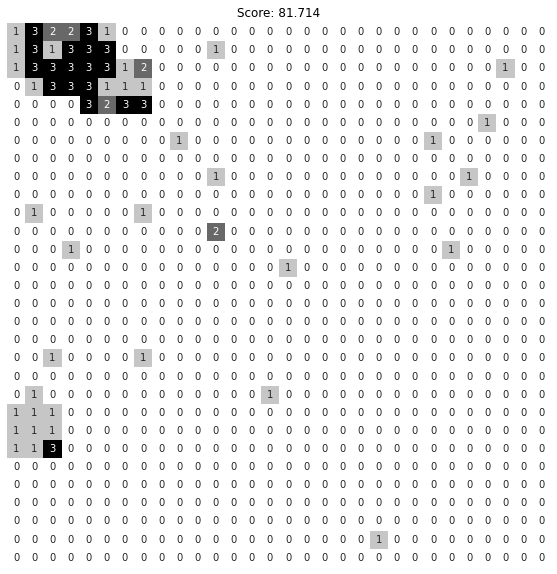

{'id': '72421935-c58b-499a-94c1-d48eb1065ad5', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


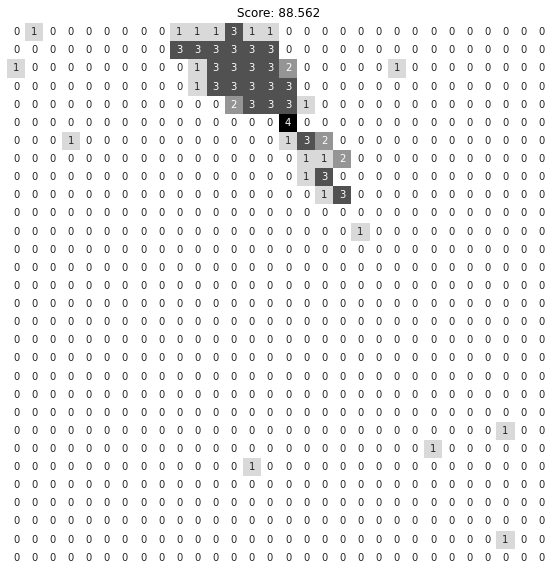

{'id': 'a095256f-e467-46b9-8dcd-8abff418aec1', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


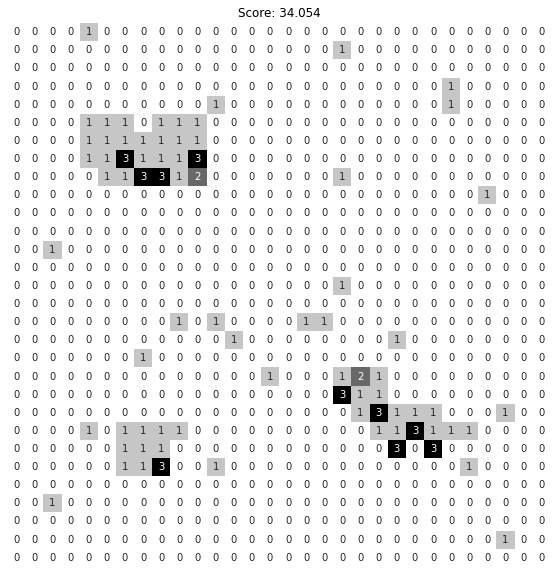

{'id': '56b97572-7f51-4973-9687-9da99b832e56', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


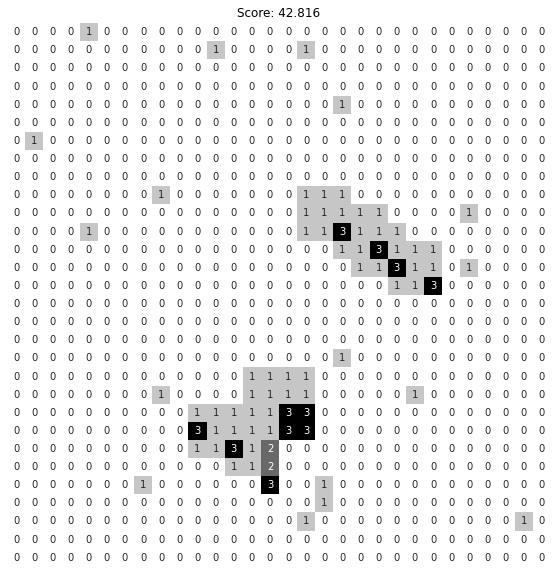

{'id': '7836ebd0-d0e2-47cd-b2d5-ddc4b895d560', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


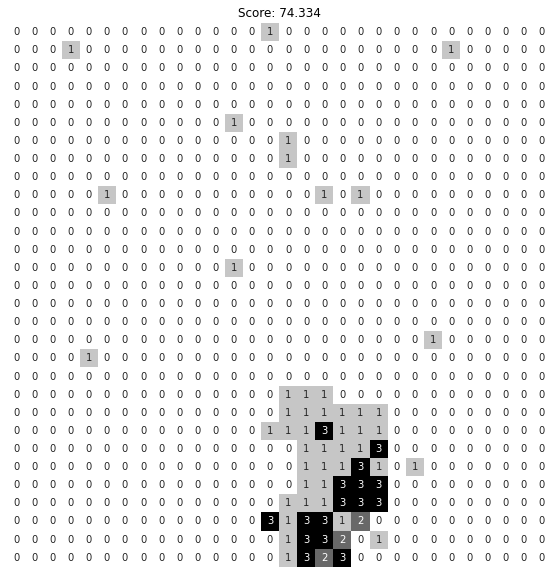

{'id': '4b4cf049-4193-456d-84bc-7e9b2fba427c', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


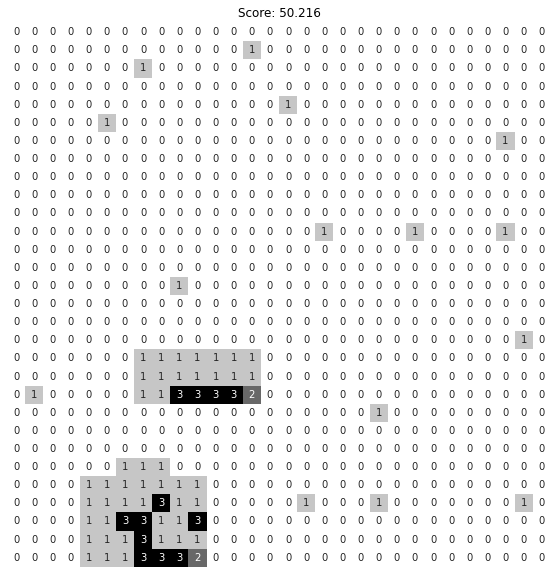

{'id': 'a6dad09e-c8fc-4cb3-8754-ab5dda659190', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


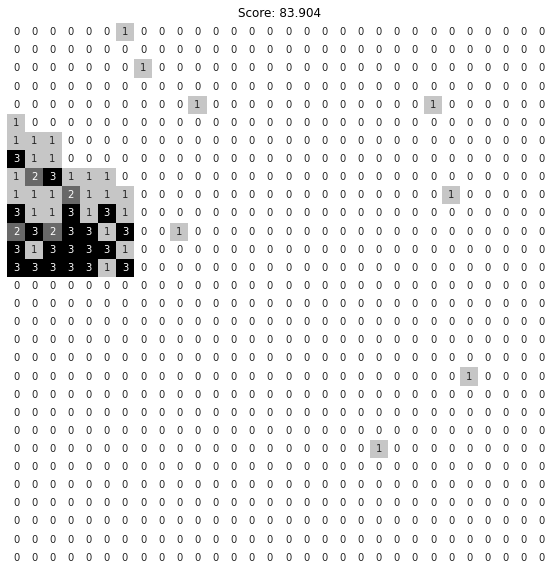

{'id': '3c8d3025-bf94-4e69-afb3-5cd364c5d28c', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


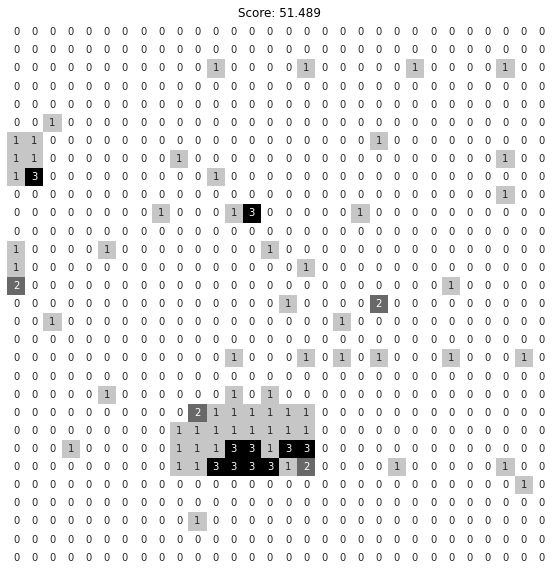

{'id': 'c3bca8df-fd66-45cb-ac3d-ddbbed95aa74', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


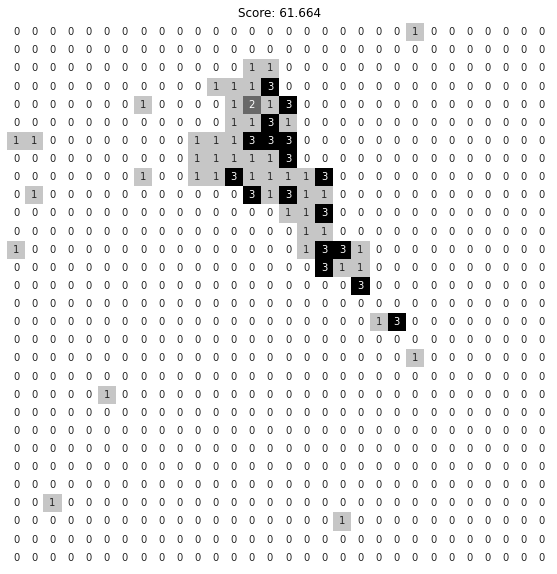

{'id': '6f54f93c-1696-42c1-a618-54ac4c672d1d', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


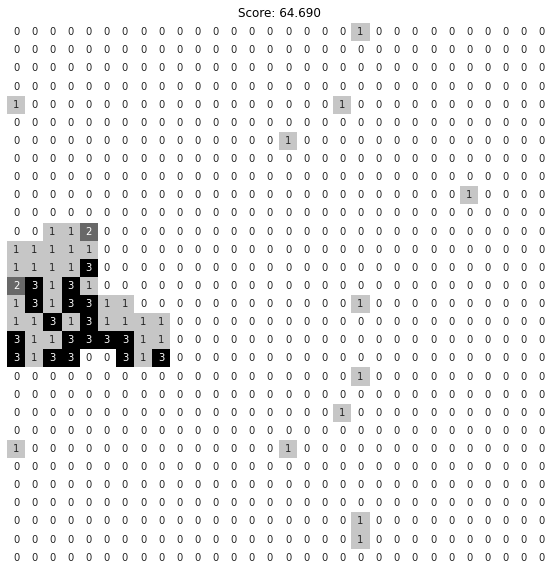

{'id': '71df303d-ca13-41bf-86d5-d3859d882f9e', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


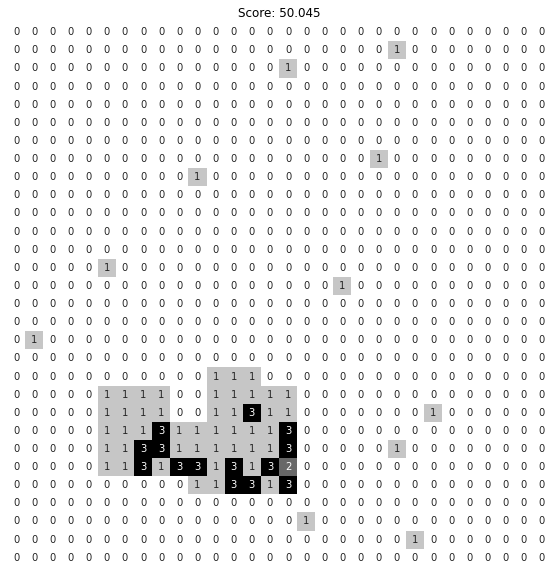

{'id': 'dd7b8774-d51d-42fe-a6e2-2dc1c4ec1069', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


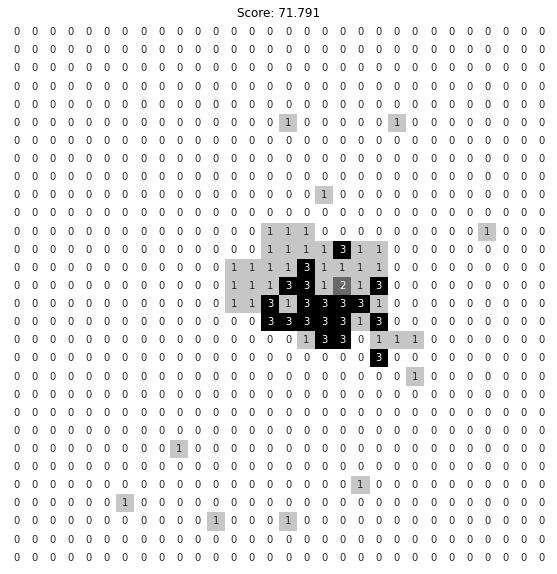

{'id': '3e6776b5-d43b-44ea-87b2-5c819dca1fb8', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


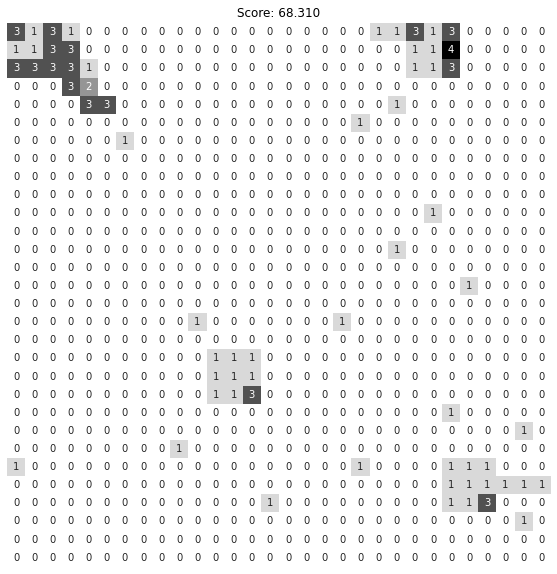

{'id': '39714ef9-0c29-4d03-a40f-b7e90f98cc3b', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


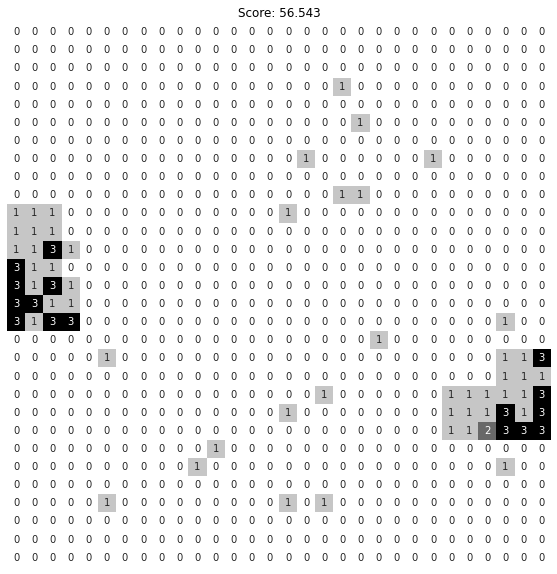

{'id': 'c5c132dd-81e9-4c94-8ce6-cc14db13c9aa', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


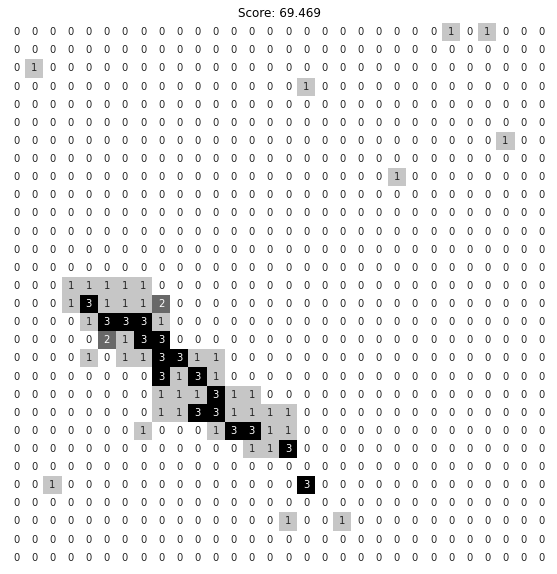

{'id': '9a28ac18-00eb-416e-94a1-b01ba783616c', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


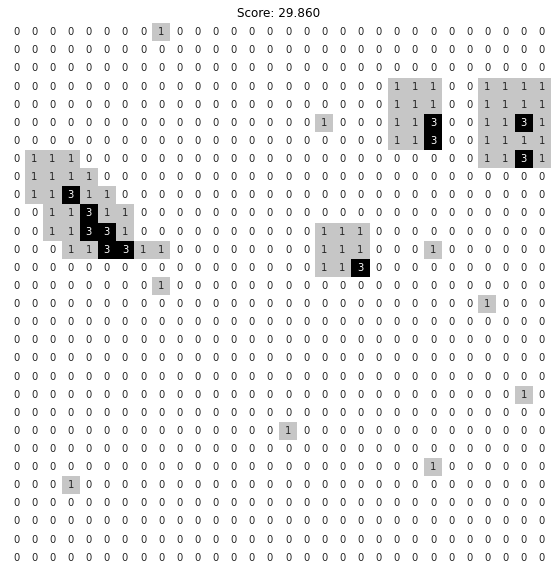

{'id': 'ea4cd0df-a8a8-4876-b530-4f1073d123a2', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


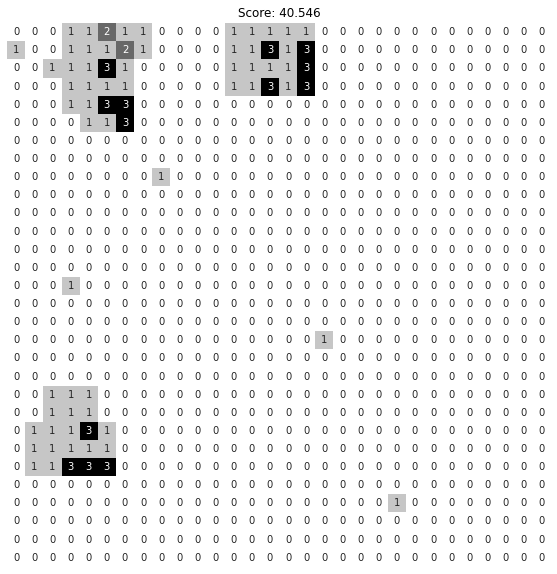

{'id': '978aabdf-5fba-4089-871b-9cbe3322b8b2', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


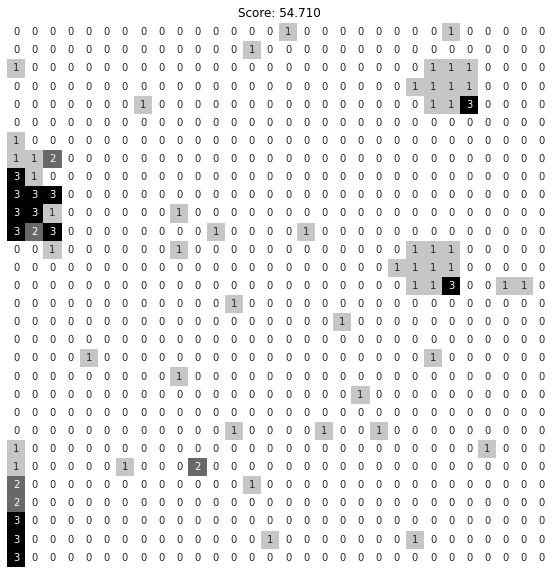

{'id': '8d140cfe-2fae-4f4f-b67f-e49bac3665f5', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


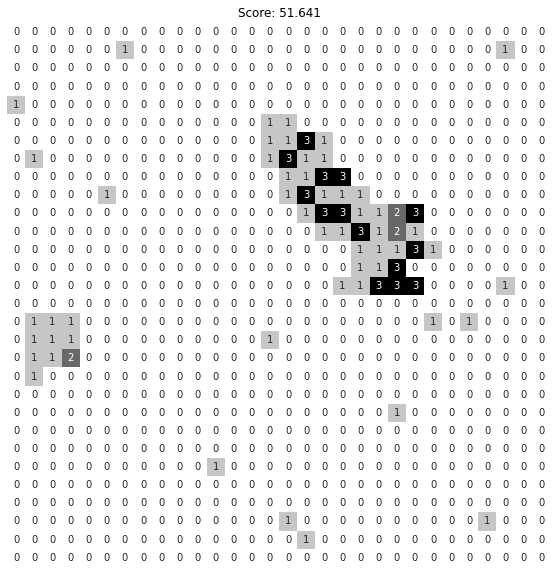

{'id': 'b33950de-34ac-4e8f-82cf-b9d2f367f0f9', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


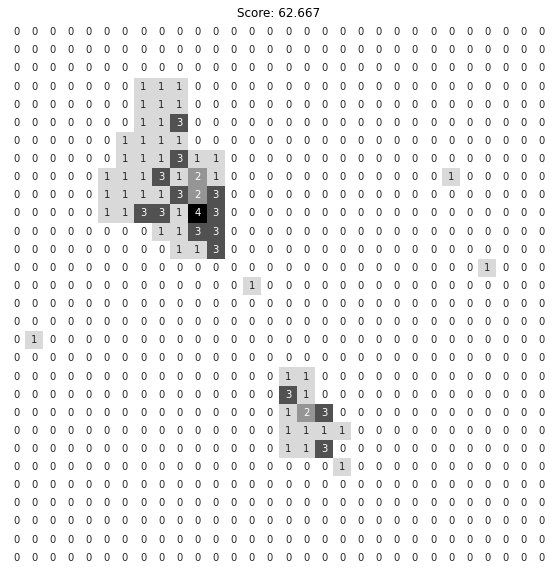

{'id': '0263e36a-5bd1-4558-a691-99dba574f900', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


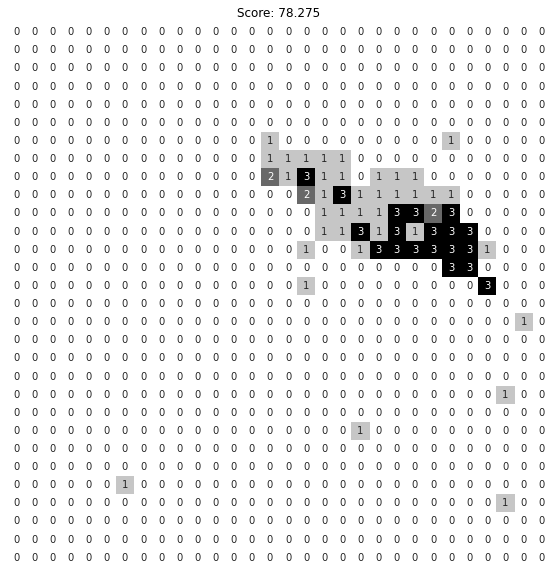

{'id': 'bb3c812d-67dd-4d92-8414-1139587e3720', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


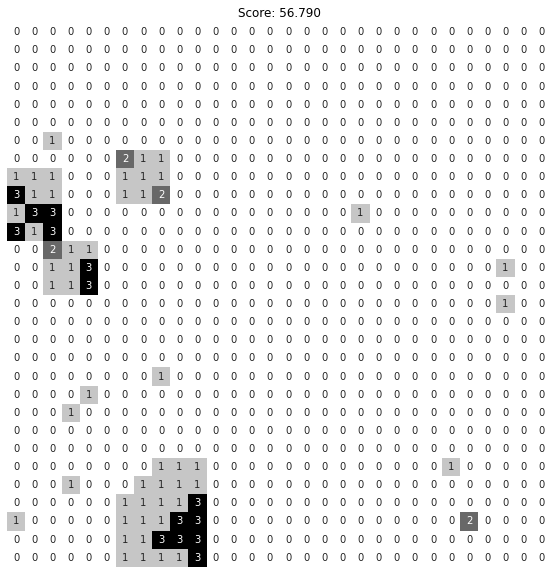

{'id': 'a552d029-b907-4fa6-8f11-f18a16e40a2d', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


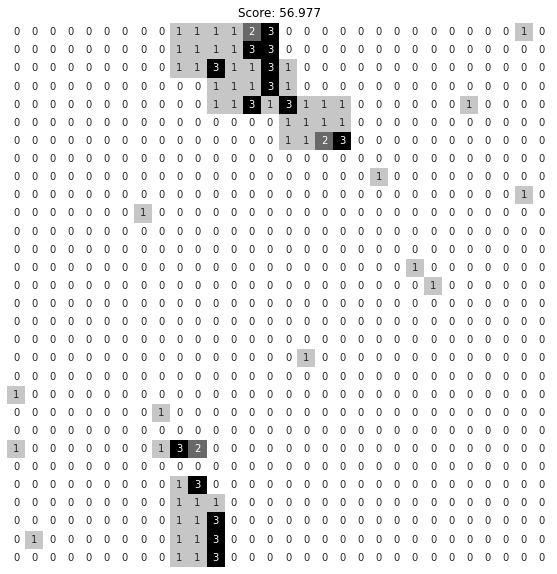

{'id': '14f077f1-cf5b-408e-af61-dd6bc50166ec', 'grid_dims': [30, 30], 'digs_remaining': 100, 'score': 0.0, 'message': 'Let the digging begin! digs_remaining: 100, score: 0.0'}


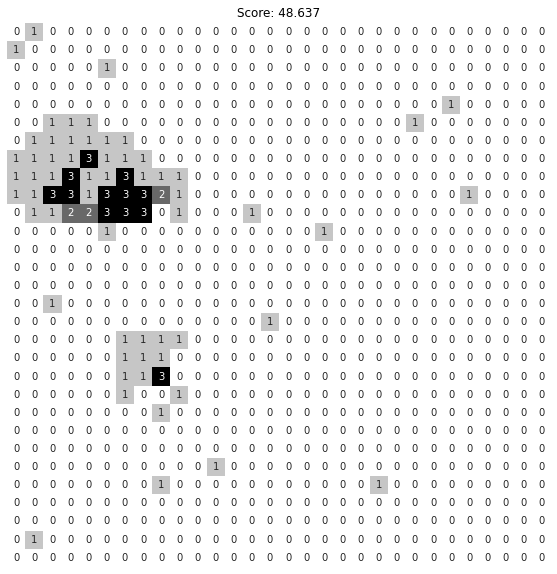

In [12]:
scores2 = []
for i in range(30):
    a2 = DepthBreath(3)
    test_agent(a2)
    scores2.append(a2.g.score)
scores2 = np.array(scores2)
sns.boxplot(scores2)
plt.title("Depth(3) Breath")

In [42]:
res = requests.get(url="https://api.gaimbot.com/games/gold-retriever/username")
res.json()

'spaghettolover'

In [43]:
res = requests.get(url="https://api.gaimbot.com/games/gold-retriever/leaderboard/me")
res.text

'{"score":111.60205685434491,"rank":14}'

In [44]:
res = requests.get(url="https://api.gaimbot.com/games/gold-retriever/leaderboard")
soup = BeautifulSoup(res.text, "html.parser")
print(soup.body.get_text().strip().replace('\n\n',''))

username
score
1
duck
123.628842
2
spaghettolover
111.602057
3
bleu
111.522809
4
254chickens
100.864632
5
Fauxtrot
94.367809
6
Glod_Glodssen
93.023539
7
dboy
90.966137
8
xemonh
88.558378
9
its_me_Fauxtrot
85.050603
10
Quillox
82.275592
11
TinyTree
78.225999
12
edgybunny
66.921095
13
usergtfo
62.550537
14
neb
43.794011
15
sleepyspoon6588
40.542584
